In [1]:
import requests        # for making http requests to binance
import json            # for parsing what binance sends back to us
import pandas as pd    # for storing and manipulating the data we get back
import numpy as np     # numerical python

import matplotlib.pyplot as plt # for charts and such
    
import datetime as dt  # for dealing with times

In [2]:
#URL for binance API
root_url = 'https://api.binance.com/api/v1/klines'

In [3]:
#function to pull data from binance API
def get_bars(symbol, interval = '1d'):
    url = root_url + '?symbol=' + symbol + '&interval=' + interval
    data = json.loads(requests.get(url).text)
    df = pd.DataFrame(data)
    df.columns = ['open_time',
                 'open', 'high', 'low', 'close', 'volume',
                 'close_time', 'qav', 'num_trades',
                 'taker_base_vol', 'taker_quote_vol', 'ignore']
    df.index = [dt.datetime.fromtimestamp(x/1000.0) for x in df.close_time]
    df = df[[ 'open', 'high', 'low', 'close', 'volume', 'num_trades']]
    return df

#### Currency Sector

In [4]:
#array to store each coin's closing prices series
coins = []
#creates Bitcoin Dataframe
btcusdt = get_bars('BTCUSDT')
#creates Bitcoin Cash Dataframe
bchusdt = get_bars('BCHUSDT')
#creates Litcoin Dataframe
ltcusdt = get_bars('LTCUSDT')

#create Pandas series for each coin's closing prices
btcclose = btcusdt.close.astype(float)
bchclose = bchusdt.close.astype(float)
ltcclose = ltcusdt.close.astype(float)
coins.extend([btcclose, bchclose, ltcclose])


#### Infrastructure Sector

In [5]:
#creates Etherium Dataframe
ethusdt = get_bars('ETHUSDT')
#creates Cardano Dataframe
adausdt = get_bars('ADAUSDT')
#creates EOS Dataframe
eosusdt = get_bars('EOSUSDT')


ethclose = ethusdt.close.astype(float)
adaclose = adausdt.close.astype(float)
eosclose = eosusdt.close.astype(float)
coins.extend([ethclose, adaclose, eosclose])


#### Financial Sector

In [6]:
#creates Chainlink Dataframe
linkusdt = get_bars('LINKUSDT')
#creates BNB Dataframe
bnbusdt = get_bars('BNBUSDT')
#creates 0x Dataframe
zrxusdt = get_bars('ZRXUSDT')


linkclose = linkusdt.close.astype(float)
bnbclose = bnbusdt.close.astype(float)
zrxclose = zrxusdt.close.astype(float)
coins.extend([linkclose, bnbclose, zrxclose])


#### Services Sector

In [7]:
#creates Numeraire Dataframe
nmrusdt = get_bars('NMRUSDT')
#creates Enjin Coin Dataframe
enjusdt = get_bars('ENJUSDT')
#creates Siacoin Dataframe
scusdt = get_bars('SCUSDT')


nmrclose = nmrusdt.close.astype(float)
enjclose = enjusdt.close.astype(float)
scclose = scusdt.close.astype(float)
coins.extend([nmrclose, enjclose, scclose])


#### Media and Entertainment Sector

In [8]:
#creates Basic Attention Dataframe
batusdt = get_bars('BATUSDT')
#creates Steem Dataframe
steembtc = get_bars('STEEMBTC')
#convert from steem/btc to steem/usd 
steemusdt = steembtc[['open', 'high', 'low', 'close']].astype('float') * btcusdt[['open', 'high', 'low', 'close']].astype('float')
#creates Fun Fair Dataframe
funusdt = get_bars('FUNUSDT')


batclose = batusdt.close.astype(float)
steemclose = steemusdt.close.astype(float)
funclose = funusdt.close.astype(float)
coins.extend([batclose, steemclose, funclose])

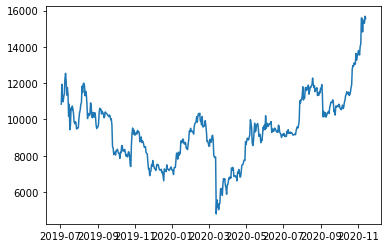

In [9]:
#BINANCE BTC PLOT
plt.plot(btcclose)
plt.show()

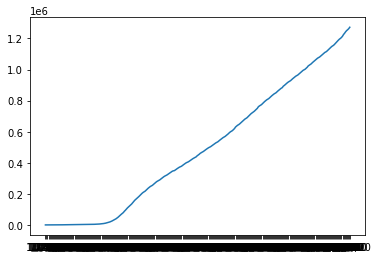

In [10]:
#GLOBAL CONFIRMED COVID DEATHS PLOT
global_deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
gd_df = pd.read_csv(global_deaths_url, error_bad_lines=False)
plt.plot(gd_df.iloc[0:, 4:].sum(axis=0))

##### Aggregating and averaging government stringency

In [11]:
stringency_df = pd.read_csv('/Users/daniellicht/Downloads/covid-stringency-index.csv')

In [12]:
from collections import defaultdict

In [13]:
date_to_aggregate_score = {}#defaultdict(list)
for i in range(0, len(stringency_df)):
    if stringency_df.iloc[i].Date in date_to_aggregate_score:
        date_to_aggregate_score[stringency_df.iloc[i].Date][0]+=stringency_df.iloc[i]["Stringency Index (OxBSG)"]
        date_to_aggregate_score[stringency_df.iloc[i].Date][1]+=1
    else:
        date_to_aggregate_score[stringency_df.iloc[i].Date]=[stringency_df.iloc[i]["Stringency Index (OxBSG)"], 1]


In [14]:
date_to_avg = {}
for date in date_to_aggregate_score:
    date_to_avg[date]=date_to_aggregate_score[date][0]/date_to_aggregate_score[date][1]


In [15]:
#IMPORTS FOR LSTM
import numpy as np
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, LSTM, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [16]:
#GATHERING S&P 500 PRICE POINTS
import yfinance as yf
import time
from datetime import date, timedelta

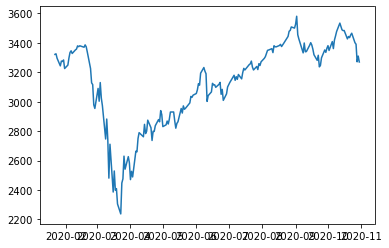

In [17]:
GSPC = yf.Ticker("^GSPC")

snp = GSPC.history(interval="1d", start="2020-01-22", end="2020-10-31").Close
#PLOT OF S&P 500
plt.plot(snp)
num_days = 284
date_index = pd.date_range(date(2020, 1, 22), periods=num_days, freq='D')
snp = snp.reindex(index=date_index)   #gather data from 1/22-10/31
snp = snp.shift(1)     #shift to use preceding day as feature in LSTM
snp.iloc[0] = 0


In [18]:
#GATHER AND REINDEX COVID CASE DATA FROM 1/22-10/31
global_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
gc_df = pd.read_csv(global_cases_url, error_bad_lines=False)
covid_cases = gc_df.iloc[0:, 4:].sum(axis=0)
covid_cases = covid_cases.shift(1)     #shift to use preceding day as feature in LSTM
covid_cases.iloc[0] = 0
covid_cases = covid_cases.iloc[:-10]
covid_cases = covid_cases.reindex(index=date_index)
covid_cases


2020-01-22           0.0
2020-01-23         555.0
2020-01-24         654.0
2020-01-25         941.0
2020-01-26        1434.0
                 ...    
2020-10-27    43485889.0
2020-10-28    43954797.0
2020-10-29    44463732.0
2020-10-30    45014520.0
2020-10-31    45583754.0
Freq: D, Length: 284, dtype: float64

In [19]:
names = ["BTC", "BCH", "LTC", "ETC", "ADA", "EOS", "LINK", "BNB", "ZRX", "NMR", "ENJ", "SC", "BAT", "STEEM", "FUN"]
len(names)

15

In [20]:
strin_vals = list(date_to_avg.values())[20:-5]  #process stringency scores for LSTM input
strin_vals[0]=0
stringency = pd.Series(data=strin_vals, index=date_index)
for idx in range(len(snp)):       #fill missing daily vals w/previous day's val
    if np.isnan(snp[idx]):
        snp[idx] = snp[idx-1]
        
#create map of coin names to inputs and output for each coin to be fit in LSTM
datasets = {}
for idx in range(len(names)):
    #for now, skipping coins lacking sufficient datapoints
    if names[idx]=='NMR' or names[idx]=='SC' or names[idx]=='BCH' or names[idx]=='FUN':
        continue
    coin_2020 = coins[idx][206:490]
    coin_2020.index=date_index   #.set_index(index=date_index)
    shifted_coin = coin_2020.shift(1)
    shifted_coin.iloc[0] = 0
    datasets[names[idx]] = pd.DataFrame({'Coin Shifted': shifted_coin, 'S&P': snp, 'Gov Stringency': stringency,  'Coin': coin_2020})
print(datasets['BTC'])


            Coin Shifted          S&P  Gov Stringency      Coin
2020-01-22          0.00     0.000000        0.000000   8439.00
2020-01-23       8439.00  3321.750000        1.629243   8340.58
2020-01-24       8340.58  3325.540039        2.209892   8615.00
2020-01-25       8615.00  3295.469971        2.560324   8907.57
2020-01-26       8907.57  3295.469971        2.755514   9374.21
...                  ...          ...             ...       ...
2020-10-27      13266.40  3400.969971       52.048774  13455.70
2020-10-28      13455.70  3390.679932       51.908623  13560.10
2020-10-29      13560.10  3271.030029       51.280677  13791.00
2020-10-30      13791.00  3310.110107       51.288649  13761.50
2020-10-31      13761.50  3269.959961       53.291406  13549.37

[284 rows x 4 columns]


##### Example of LSTM being run on Bitcoin pricing

In [21]:
dataset = datasets['BTC']

# scale inputs and output to [0, 1] range to improve performance
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset.values)
inverted_X = scaler.inverse_transform(scaled)
inverted_X

values = scaled

# split into train and test sets
train_size = int(num_days*0.60)
test_size = num_days-train_size

train = values[:train_size, :]
test = values[train_size:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


In [22]:
#LSTM ARCHITECTURE
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit model
history = model.fit(train_X, train_y, epochs=110, batch_size=16, validation_data=(test_X, test_y), verbose=0, shuffle=False)


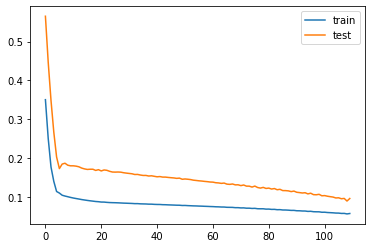

In [23]:
#GRAPH OF LOSS FUNCTIONS
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()



In [24]:
#PLOT PREDICTIONS FOR ENTIRE TIME SERIES AGAINST ACTUAL VALUES
predictions = []
for i in range(len(dataset.values)):
    X, y = values[i, 0:-1], values[i, -1]
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=1)
    yhat = yhat[0,0]
    
    #invert scaler
    new_row = X[0][0]
    new_row = np.concatenate((new_row, [yhat]))
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    yhat = inverted[0, -1]
    yhat = yhat+dataset.values[-(len(dataset.values)-i)]
    predictions.append(yhat)
    
#RUN COMMENTED CODE TO JUST SHOW PREDICTIONS ON TEST DATA
#     X, y = test[i, 0:-1], test[i, -1]
#     X = X.reshape(1, 1, len(X))
#     yhat = model.predict(X, batch_size=1)
#     yhat = yhat[0,0]
    
#     #invert scaler
#     new_row = X[0][0]
#     new_row = np.concatenate((new_row, [yhat]))
#     array = np.array(new_row)
#     array = array.reshape(1, len(array))
#     inverted = scaler.inverse_transform(array)
#     yhat = inverted[0, -1]
#     yhat = yhat+inverted_X[-(len(test)-i)]
#     predictions.append(yhat)


##### Predictions are blue, actual closing prices are red. Scales of graph are off

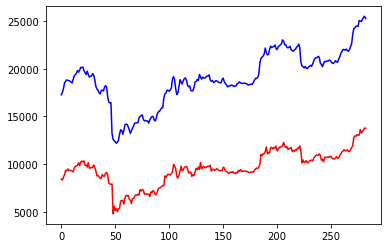

In [25]:
prediction_graph_vals = np.array([prediction[-1] for prediction in predictions])
prediction_graph_vals
plt.plot(inverted_X[1:,:-3], color='red')
plt.plot(prediction_graph_vals[1:], color='blue')
plt.show()